<div style="text-align:center">
    <h1>
        REINFORCE
    </h1>
</div>

<br><br>

<div style="text-align:center">
In this notebook we are going to implement the Monte Carlo version of Policy Gradient methods. The REINFORCE algorithm uses the full return to update the policy:
</div>

\begin{equation}
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+1} + \cdots + \gamma^{T-t-1} R_{T}
\end{equation}


<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 10 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import os
import torch
import gym
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW

from utils import test_policy_network, seed_everything, plot_stats, plot_action_probs
from parallel_env import ParallelEnv, ParallelWrapper

## Create and preprocess the environment

### Create the environment

In [2]:
env = gym.make('CartPole-v0')

In [3]:
dims = env.observation_space.shape[0]
actions = env.action_space.n
print(f'CartPole has {dims} state dimensions and {actions} possible actions')
print(f'Sample state {env.reset()}')

CartPole has 4 state dimensions and 2 possible actions
Sample state [-0.03183224  0.04483957 -0.04601188  0.04160601]


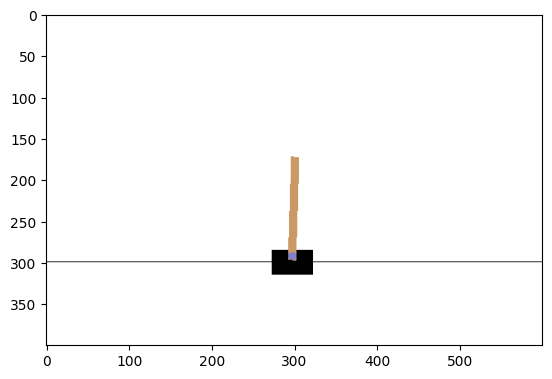

In [4]:
plt.imshow(env.render(mode='rgb_array'))

### Parallelize the environment

In [4]:
num_envs = os.cpu_count()
print(f'There are {num_envs} cpus.')

There are 16 cpus.


In [5]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env, seed=seed)

    return env

In [6]:
env_fns = [lambda: create_env('CartPole-v0', rank) for rank in range(num_envs)]
parallel_env = ParallelEnv(env_fns)

In [7]:
parallel_env.reset()

array([[ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399],
       [ 0.03186309,  0.03407994, -0.0424852 , -0.00542399]],
      dtype=float32)

### Prepare the environment to work with PyTorch

In [8]:
class PreprocessEnv(ParallelWrapper):
    def __init__(self, parallel_env):
        ParallelWrapper.__init__(self, parallel_env)

    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()

    def step_async(self, actions):
        
        # actions come in as column vectors: [[2],[3],[1],...]
        # remove the unnecessary dimensions: [2,3,1,...]
        actions = actions.squeeze(dim=1).numpy()
        self.venv.step_async(actions)

    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(dim=1).float()
        done = torch.tensor(done).unsqueeze(dim=1)
        return next_state, reward, done, info

In [9]:
parallel_env = PreprocessEnv(parallel_env)

In [10]:
state = parallel_env.reset()
_, reward, done, _ = parallel_env.step(torch.zeros(num_envs, 1, dtype=torch.int32))
print(f"State: {state}, Reward: {reward}, Done: {done}")

State: tensor([[-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389],
        [-0.0045, -0.0279,  0.0034, -0.0389]]), Reward: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), Done: tensor([[False]

### Create the policy $\pi(s)$

In [11]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1)
)

### Plot action probabilities

In [12]:
neutral_state = torch.zeros(4)
left_danger = torch.tensor([-2.3, 0., 0., 0.])
right_danger = torch.tensor([2.3, 0., 0., 0.])

#### Plot a neutral environment

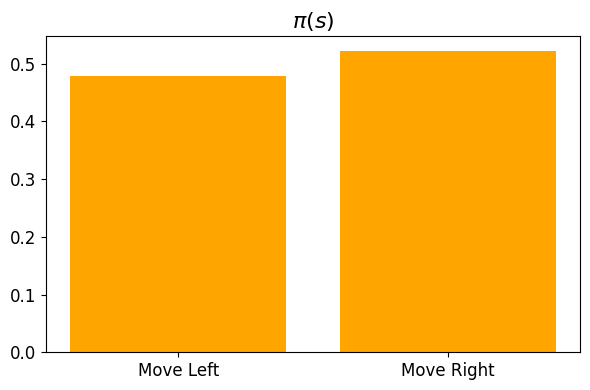

In [15]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

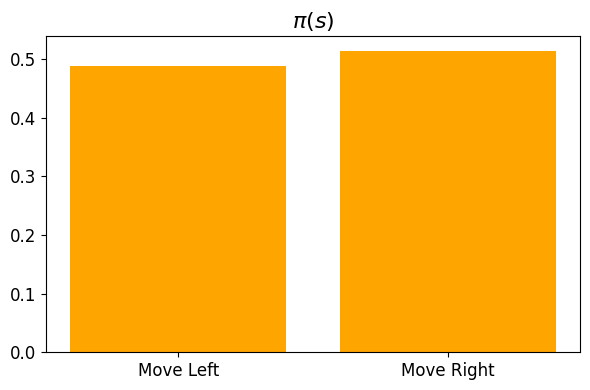

In [16]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

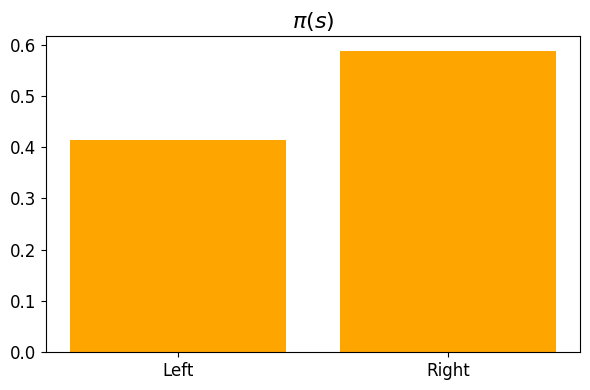

In [17]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

## Implement the algorithm

</br></br>


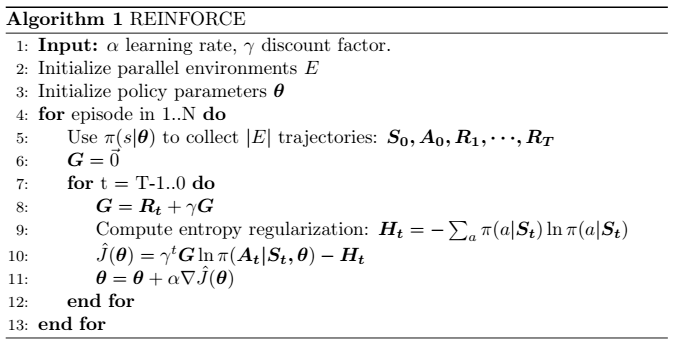

In [22]:
def reinforce(policy, episodes, alpha=1e-4, gamma=.99):
    optim = AdamW(policy.parameters(), lr=alpha)
    stats = {'Loss':[], 'Returns':[]}

    for episode in tqdm(range(1, episodes+1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        transitions = []
        episode_return = torch.zeros((num_envs, 1), dtype=torch.float)

        while not done_b.all():
            # select one action from multiple possibilities using their assign probabilities
            # will return [[2], [1], [3], [0], ...]
            action = policy(state).multinomial(1).detach()
            next_state, reward, done, _ = parallel_env.step(action)
            transitions.append([state, action, ~done_b*reward])
            episode_return += reward
            done_b |= done # 'or' logical operation between 2 tensors
            state = next_state

        G = torch.zeros((num_envs, 1))
        for t, (state_t, action_t, reward_t) in reversed(list(enumerate(transitions))):
            G = reward + gamma * G
            probs_t = policy(state_t)
            log_probs_t = torch.log(probs_t + 1e-6)
            action_log_prob_t = log_probs_t.gather(1, action_t)

            entropy_t = - torch.sum(probs_t * log_probs_t, dim=-1, keepdim=True)
            gamma_t = gamma ** t

            pg_loss_t = - gamma_t * G * action_log_prob_t
            total_loss_t = (pg_loss_t - .01 * entropy_t).mean()

            policy.zero_grad()
            total_loss_t.backward()
            optim.step()

        stats['Loss'].append(total_loss_t.item())
        stats['Returns'].append(episode_return.mean().item())

    return stats

In [23]:
stats = reinforce(policy, 1000)

100%|██████████| 1000/1000 [03:45<00:00,  4.43it/s]


## Show results

### Show execution stats

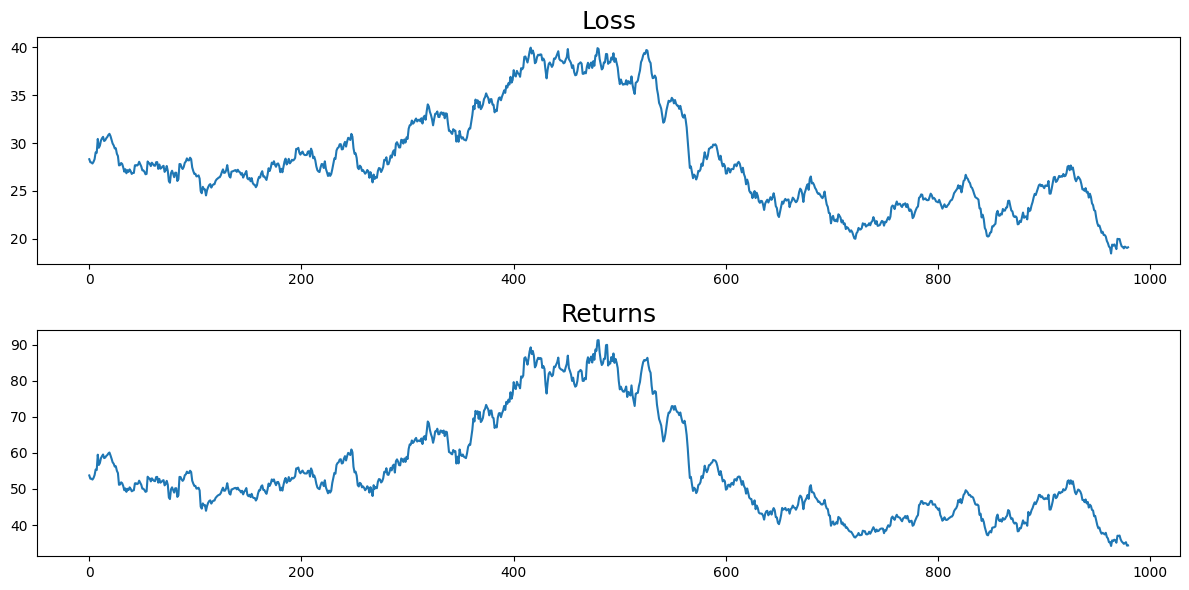

In [24]:
plot_stats(stats)

### Plot action probabilities

#### Plot a neutral environment

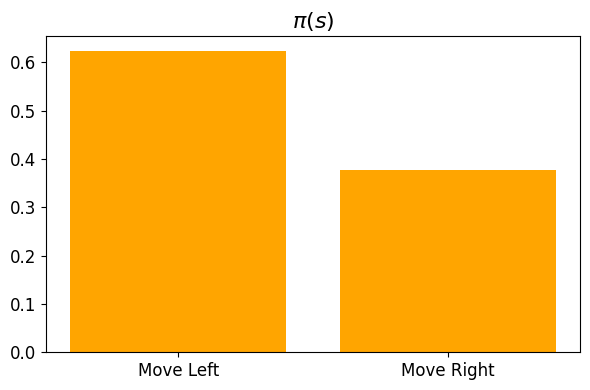

In [25]:
probs = policy(neutral_state).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far left

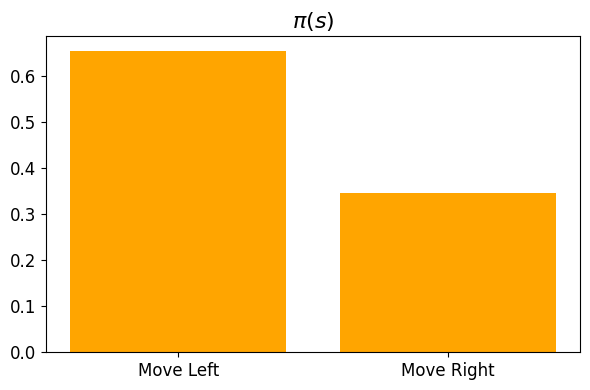

In [26]:
probs = policy(left_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Move Left', 'Move Right'])

#### Plot a state where the cart is too far right

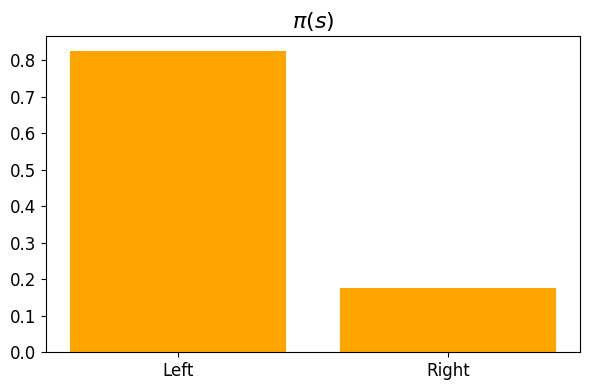

In [27]:
probs = policy(right_danger).detach().numpy()
plot_action_probs(probs=probs, labels=['Left', 'Right'])

### Test the resulting agent

In [ ]:
test_policy_network(env, policy, episodes=5)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)